# Exercise 07: Limitations of Ensemble Studies

**Assignment due:** *April 9 2019*  

In this exercise we investigate limitations of the statistical ensemble perspective on network data. In particular, we have seen that the properties of finite scale-free networks can deviate significantly from theoretical predictions obtained in the limit of infinite networks. We will explore these finite-size effects based on simulations. We further calculate the _variance_ of microstate properties within an ensemble, which helps us to assess whether expected values are a reasonable proxy for the properties of individual realisations.

In [1]:
#BOILERPLATE_CODE
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pathpy as pp
import numpy as np

from scipy.optimize import curve_fit

### Task 1:  Finite-size effects in scale-free networks

Your first task is to generate random scale-free networks with different exponents and different sizes to study finite-size effects in statistical ensembles. The generation of a scale-free network with a given exponent and size can be done using the following helper function:

In [2]:
#BOILERPLATE_CODE
def is_graphic_Erdos_Gallai(degree_sequence_to_test):
    degree_sequence = sorted(degree_sequence_to_test,reverse=True)
    S = sum(degree_sequence)
    n = len(degree_sequence)
    if S%2 != 0:
        return False
    for r in range(1, n):
        M = 0
        S = 0
        for i in range(1, r+1):
            S += degree_sequence[i-1]
        for i in range(r+1, n+1):
            M += min(r, degree_sequence[i-1])
        if S > r * (r-1) + M:
            return False
    return True


def MolloyReed(degrees, relax = False):
    # assume that we are given a graphical degree sequence
    if not is_graphic_Erdos_Gallai(degrees):
        return 0
    
    # create empty network with n nodes
    n = len(degrees)
    g = pp.Network(directed = False)
    
    # generate link stubs based on degree sequence
    stubs = []
    for i in range(n):
        for k in range(degrees[i]):
            stubs.append(i)
    
    # connect randomly chosen pairs of link stubs
    # note: if relax is True, we conceptually allow self-loops 
    # and multi-edges, but do not add them to the network/
    # This implies that the generated network may not have 
    # exactly sum(degrees)/2 links, but it ensures that the algorithm 
    # always finishes.
    while(len(stubs)>0):
        v, w = np.random.choice(stubs, 2, replace=False)
        if relax or (v!=w and ((v,w) not in g.edges.keys())):
            # do not add self-loops and multi-edges
            if (v!=w and ((v,w) not in g.edges.keys())):
                g.add_edge(str(v),str(w))
            stubs.remove(v)
            stubs.remove(w)
    return g

In [3]:
#BOILERPLATE_CODE
def generateSFNetwork(n=1000, gamma=2.1):
    degrees_zipf = [1]
    while not is_graphic_Erdos_Gallai(degrees_zipf):
        degrees_zipf = [int(x) for x in np.random.zipf(gamma, n)]
    g = MolloyReed(degrees_zipf, relax = True)
    return g

For each point in the parameter space, we then 
1. compute the relative size of the largest connected component, and 
2. the relative size of the largest surviving connected component for a uniform failure probability $q=0.3$.

For the latter part, we will reuse the function that we developed in exercise 6. 

In [4]:
#BOILERPLATE_CODE
def remove_random_frac(network, frac):
    n = network.ncount() 
    while (network.ncount()/n>1-frac):
        v = np.random.choice(list(network.nodes))
        network.remove_node(v)
    return network

To get meaningful average values, we average 20 different random realizations for each combination of the parameters $n$ and $\gamma$. This is done by the following function:

In [5]:
#BOILERPLATE_CODE
def finite_size_effects(gamma_range, size_range, q=0.3, samples=1):
    gcc_results = {}
    sgcc_results = {}
    for gamma in gamma_range:
#         print("Generating networks for gamma =", gamma)
        gcc_results[gamma] = []
        sgcc_results[gamma] = []
        for n in size_range:
            gcc = 0
            sgcc = 0
            for i in range(samples):         
                g_before = generateSFNetwork(n, gamma)
                count_before_pre = g_before.ncount()
                pp.algorithms.components.reduce_to_gcc(g_before)
                gcc += g_before.ncount()/count_before_pre
                
                g_after = remove_random_frac(g_before, q)
                count_after_pre = g_after.ncount()
                pp.algorithms.components.reduce_to_gcc(g_after)
                sgcc += g_after.ncount()/ count_after_pre
            
            gcc_results[gamma].append(gcc/samples)
            sgcc_results[gamma].append(sgcc/samples)
#             print("Finished simulations for n =", n)        
    return (gcc_results, sgcc_results)

Now use the functions above to calculate the relative size of the largest connected component before and after the node failures. Use 5 samples of different scale-free networks with exponents $\gamma \in \{2.1, 2.3, 2.5, 2.9\}$ and 20 different logarithmically spaced network sizes $n \in \left[100, 1000\right]$. Plot your results.

In [6]:
gamma_values = np.array([2.1, 2.3, 2.5, 2.9])
size_values = np.logspace(2, 3, 20, dtype=int)
colors_values = ['tomato', 'lightskyblue', 'olivedrab', 'darkmagenta']

In [7]:
gcc_results, sgcc_results = finite_size_effects(gamma_values, size_values, samples=10)

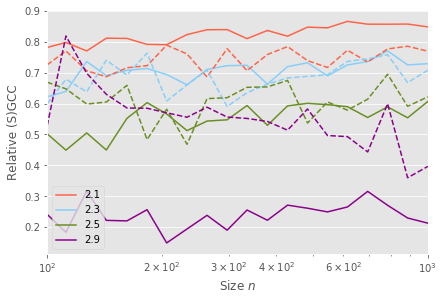

In [8]:
# fig.clf()
fig = plt.figure()
ax = plt.subplot(111)

s = 0
for gamma, result in gcc_results.items():
    ax.plot(size_values, result,'-', color=colors_values[s%4],label=r'{}'.format(gamma))
    s += 1
for gamma, result in sgcc_results.items():
    ax.plot(size_values, result,'--', color=colors_values[s%4])
    s += 1

ax.set_xlabel(r'Size $n$')
ax.set_ylabel(r'Relative (S)GCC')
ax.set_xlim(min(size_values),max(size_values))
# ax.set_ylim()
ax.set_xscale('log')
ax.legend(loc='best')
fig.tight_layout(pad=.1)
fig.savefig('./graphics/exercise_07_task_1_sgcc.pdf')

How can we interpret these findings? Based on the theory of scale-free networks, we have seen that we expect (i) a giant connected component to exist in the randomly generated network, and (ii) a giant connected component to exist in the network where 30 % of the nodes have failed at random. For any parameter $\gamma$, we observe significant deviations from this theoretical prediction. They tend to be smaller for small networks, compared to large networks. We also observe that the deviations are getting more pronounced as the exponent $\gamma$ is increased. For $\gamma$ close to three, we see that the real behavior is very far from the prediction even for networks with $1000$ nodes.

### Task 2: Variance of microstate properties

A second potential fallacy when applying ensemble average in the reasoning about real networks, is the variance of microstate properties within a statistical ensemble. In order to analyse the variance of microstates, use the $G(n,p)$ model to generate $1000$ microstates from the statistical ensemble of Erdoes-Renyi networks for $n=400$ and $np=3$. For each of these microstates, calculate the diameter and the clustering coefficient. Generate a scatter plot of the obtained values.

**Hint:** Use `alpha=0.05` in your scatter plot to better highlight the distribution of values.

In [9]:
def second_fallacy(n, np, sample_size=1000):
    diameter_values = []
    clusterig_coeff_values = []
    
    for s in range(sample_size):
        gnp = pp.algorithms.random_graphs.erdoes_renyi_gnp(n=n, p=np/n)
        pp.algorithms.components.reduce_to_gcc(gnp)
        diameter_values.append(pp.algorithms.shortest_paths.diameter(gnp))
        clusterig_coeff_values.append(pp.algorithms.statistics.avg_clustering_coefficient(gnp))
        
    fig = plt.figure()
    ax = plt.subplot(111)
    
    ax.scatter(diameter_values, clusterig_coeff_values, alpha=.05)
    ax.set_xlabel(r'Diameter $d$')
    ax.set_ylabel(r'Avg. clustering coeff.')
    fig.savefig('./graphics/exercise_07_task_2_variance.pdf')
    
    return diameter_values

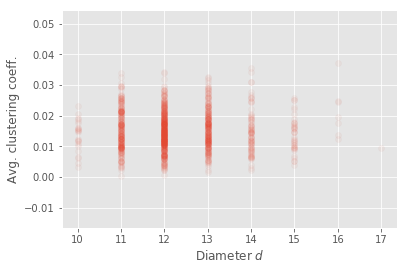

In [10]:
diameters = second_fallacy(400, 3.)

Compute the mean and the standard deviation of the diameters within your sample:

In [11]:
print('Mean: {0:.2f} and diameter: {1:.2f} of the diameter.'.format(np.mean(diameters), np.std(diameters)))

Mean: 12.28 and diameter: 1.13 of the diameter.


### Task 3: Fitting degree distributions

Generate a degree sequence drawn from a **log-normal** distribution with a mean of $2$, a standard deviation of $1$ and a network size $n = 5000$. 
For this task, we need the degrees to be integers and larger than zero, which you can achieve by using the function `np.ceil`.
We could use the `MolloyReed` function to generate a network with this degree sequence, but we don't need the actual network for this task.

In [12]:
degrees_lognorm = np.ceil(np.random.lognormal(mean=2., sigma=1., size=5000))

The following helper function generates a log-log histogram of the degree distribution of this network. This function takes a `bins` argument that allows us to change the bin size used in the histogram calculation.

In [13]:
#BOILERPLATE_CODE
def plot_degree_dist(degrees, bins, log=True):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    ax.hist(degrees, bins=bins, density = True, facecolor = 'b', alpha = 0.75, log=log)
    #plt.scatter(degrees, p)
    ax.axis([min(bins), max(bins), 10**(-6), 1])
    ax.grid(True) 
    ax.set_xlabel(r'$k$')
    ax.set_ylabel(r'$P(k)$')
    ax.set_xscale('log')
    
    fig.tight_layout(pad=.1)
    fig.savefig('./graphics/exercise_07_task_3_log_normal.pdf')

Use the function above to plot a histogram of degrees in log-log space. Use 15 logarithmically-spaced bins in the range from 1 to the maximum degree.

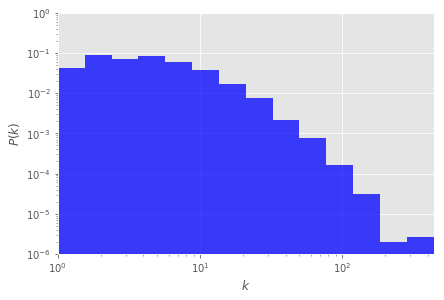

In [14]:
bins = np.logspace(0, np.log10(max(degrees_lognorm)),15)
plot_degree_dist(degrees_lognorm, bins)

Apart from the smallest degrees (smaller than approx. 5) this approximately looks like a straight line in a log-log space, which would indicate a powerlaw distribution (and thus a scale-free network).
In the following, we will compare this hypothesis to the hypothesis that the data was drawn from a lognormal distribution (which we know it was).
For this, we provide you with functions that compute the probability density functions of the lognormal and powerlaw distribution. We will later use those to calculate the model likelihoods given the empirical degree distribution.

In [15]:
#BOILERPLATE_CODE
lognormal = lambda x, mu, sigma: ((1/x/sigma/np.sqrt(2*np.pi))*
                           np.exp((-(np.log(x)-mu)**2)/2/sigma**2))
powerlaw = lambda x, gamma, a: a*x**(-gamma)

### Task 3.1 Fitting a power law distribution

In order to fit the power law distribution to the data, we will use a dirty trick (which you should not try at home). Instead of the actual data, we will use the binned data from the log-log histogram above to fit a linear model in log-space. For the fitting we need pairs x, y where x is the middle point of each bin and y is the height of that bin. The following function computes these x, y value pairs for the empirical degree distribution and the logarithmically-spaced bins chosen above. Note that the values returned are in logarithmic space.

In [16]:
#BOILERPLATE_CODE
def get_xy(degrees_lognorm, bins):
    # returns the side of the bins
    y, x_sides = np.histogram(degrees_lognorm, bins=bins, density=True)
    x = [(x_sides[i]+x_sides[i+1])/2 for i in range(len(x_sides)-1)]
    x_new = []
    y_new = []
    for i in range(len(y)):
        if y[i] != 0.0:
            x_new.append(x[i])
            y_new.append(y[i])
    return np.array(np.log10(x_new)), np.array(np.log10(y_new))

log_x, log_y = get_xy(degrees_lognorm, bins)

We now use our trick to fit the power law distribution to the data. Since a power law in linear space is simply a straight line in log-log-space we can fit the slope of a linear model based on the data points x, y that we have created above.

To do this, you can use the function `curve_fit` from the module `scipy.optimize`. For your convenience, we provide you with a lambda function that represents a linear model with two parameters alpha (the slope of the line) and beta (the intercept, i.e. where the line crosses the y-axis). The argument x has to be first due to the convention of [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [17]:
#BOILERPLATE_CODE
linear_model = lambda x, alpha, beta: alpha*x+beta

[alpha, beta], pcov = curve_fit(linear_model, log_x, log_y)
print(alpha, beta)

-1.9637208660554508 0.003222929376053285


Use the solution generated by `curve_fit` to fit the slope `alpha` and the intercept `beta` of the linear model. You can now use those to calculate the exponent `gamma` and the scale parameter `a` of the powerlaw distribution. $\mathrm{log}(a \cdot k^{-\gamma}) = log(a) - \gamma  log(k) = \beta + \alpha \cdot x \rightarrow \alpha = - \gamma$ and $\beta = \mathrm{log}(a)$.

In [18]:
print('gamma: {:.2f} and a: {:.2f}'.format(-alpha, np.exp(beta)))

gamma: 1.96 and a: 1.00


Plot the histogram with the bins above, using `density=True` as well as the fitted power law.

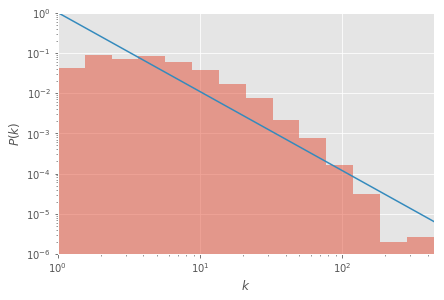

In [19]:
fig = plt.figure()
ax = plt.subplot(111)

ax.hist(degrees_lognorm, bins=bins, density = True, alpha=0.5, log=True)
ax.plot(bins, np.exp(beta) * bins**(alpha), '-')
#plt.scatter(degrees, p)
ax.axis([min(bins), max(bins), 10**(-6), 1])
ax.grid(True) 
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_xscale('log')

fig.tight_layout(pad=.1)
fig.savefig('./graphics/exercise_07_task_3_fit.pdf')

### Task 3.2 Comparing hypotheses based on Likelihood

While the exponent `gamma` found above represent the best possible fit of a power law distribution to the data, this does **not** imply that the degree distribution actually follows a power law. We rather have to compare the support for this hypothesis against other, alternative hypotheses regarding the true distribution. here, we actually know know that the data was generated from a lognormal distribution, so this is the alternative hypothesis that we want to compare against.

There exist different ways to compare hypotheses (and test one null hypothesis against an alternative). Here we use a maximally simple, heuristic approach to compare the **model likelihoods** to each other, i.e. we compare the probabilities with which each of the two models would generate the empirical data.

We start with the power law distribution. Use the function `llh_powerlaw` given below to calculate the log-likelihood of the fitted powerlaw model given the empirical degree sequence above.

In [20]:
#BOILERPLATE_CODE
def llh_powerlaw(x, gamma, a):
    llh_each = np.log(a)-gamma*np.log(x)
    return np.sum(llh_each)

In [21]:
log_likelihood_powerlaw = llh_powerlaw(bins, -alpha, np.exp(beta))

We now want to compare this likelihood to the likelihood of a lognormal distribution that we fit to the data. We can actually fit such a model by maximising the log-likelihood of the model given the data. This is a widely used method that we will discuss in more detail in one of the next lectures. There are different optimisation methods, that we can use to maximise the likelihood. Here we use a variant of a [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm, which is based on a simple idea: Considering that the lognormal distribution has two parameters `mu` and `sigma`, we start with a random point in a two-dimensional parameter space. We then apply an iterative algorithm. In each step, we 1) calculate the likelihood of the current parameters, 2) compare this likelihood to the likelihoods of four neighbouring points at a certain distance `d` in different directions, and 3) move to the neighbouring point with the maximum likelihood if it is larger than the current likelihood. Whenever we remain in the same point, we decrease the distance `d`, i.e. we take smaller steps to find a maximum.

This simple method is implemented in the following function:

In [22]:
#BOILERPLATE_CODE
def llh_lognorm(x, mu, sigma):
    p_each = lognormal(x, mu, sigma)
    llh_each = np.log(p_each)
    return np.sum(llh_each)


def MLE_lognormal(x, mu0=1.0, sig0=1.0, iterations=1000):
    r""" Performs a gradient descent maximisation of the log-likelihood 
    of a lognormal distribution given the empirical data x.
    """
    max_m = mu0
    max_s = sig0
    dm = 0.5
    ds = 0.5
    for i in range(iterations):
        prev_m = max_m
        prev_s = max_s
        # check four points around the point [m,s] in the 
        # parameter space at distances dm and ds
        for new_m, new_s in [[max_m-dm, max_s], [max_m+dm, max_s], [max_m, max_s+ds], [max_m, max_s-ds]]:
            # accept the move if one of the new values is giving a higher likelihood 
            if llh_lognorm(x, max_m, max_s) < llh_lognorm(x, new_m, new_s):
                max_m = new_m
                max_s = new_s
        # if we remain at the same point, decrease the distances dm, ds
        if max_m==prev_m and max_s==prev_s:
            dm = 1/(i+1)
            ds = 1/(i+1)
    return max_m, max_s

Use the function `MLE_lognormal` above to find the parameters `mu_opt` and `sigma_opt` that maximise the likelihood of the lognormal model given the empirical degree distribution. Plot both the histogram of degrees as well as the fitted lognormal distribution (using the function `lognormal` from above).

Now calculate the likelihood of the lognormal model given the data and compare it to the likelihood of the power law distribution obtained above. Which hypothesis would you prefer?